In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy as sp
import pywt
import os

In [12]:
trial_type_names = ['HC Hit', 'HC Miss', 
                    'MC Hit', 'MC Miss', 'MC No Report',
                    'False Alarm', 'Correct Rejection', 'LC No Report']
mouse_names = ['cfm001', 'cfm002', 'cfm003', 'cmm001', 'cmm002', 'cmm003', 'rfm001', 'rfm002', 'rfm003']

for mouse_name in mouse_names:
    print(mouse_name)
    h5_path = f"/Volumes/T7 Shield2/BehaviorDataBackup/KatiesResults/results/{mouse_name}_dynamic_spec.h5"

    with h5py.File(h5_path, 'r') as h5_file:
        for i in range(len(trial_type_names)):
            T = h5_file[trial_type_names[i]].attrs['Time_Array'][()]
            print(f'{trial_type_names[i]}: {len(T)}')

cfm001
HC Hit: 250
HC Miss: 314
MC Hit: 314
MC Miss: 314
MC No Report: 81
False Alarm: 314
Correct Rejection: 314
LC No Report: 314
cfm002
HC Hit: 314
HC Miss: 285
MC Hit: 314
MC Miss: 314
MC No Report: 247
False Alarm: 314
Correct Rejection: 314
LC No Report: 314
cfm003
HC Hit: 314
HC Miss: 252
MC Hit: 211
MC Miss: 108
MC No Report: 314
False Alarm: 314
Correct Rejection: 314
LC No Report: 314
cmm001
HC Hit: 314
HC Miss: 314
MC Hit: 314
MC Miss: 314
MC No Report: 314
False Alarm: 314
Correct Rejection: 314
LC No Report: 110
cmm002
HC Hit: 112
HC Miss: 314
MC Hit: 314
MC Miss: 314
MC No Report: 157
False Alarm: 314
Correct Rejection: 314
LC No Report: 314
cmm003
HC Hit: 265
HC Miss: 245
MC Hit: 314
MC Miss: 184
MC No Report: 314
False Alarm: 314
Correct Rejection: 257
LC No Report: 314
rfm001
HC Hit: 314
HC Miss: 314
MC Hit: 314
MC Miss: 314
MC No Report: 244
False Alarm: 314
Correct Rejection: 314
LC No Report: 314
rfm002
HC Hit: 155
HC Miss: 271
MC Hit: 314
MC Miss: 314
MC No Report:

In [9]:
def dynamic_spectrum(signal, fps, plot=False):
    """
    Computes the dynamic spectrum (time-frequency array) of a 1D signal using the Complex Morlet Wavelet.
    Args:
    - signal (numpy.ndarray): 1D array representing the signal over time.
    - fps (float): Frames per second of the signal =
    - plot (bool, optional): If True, plots the dynamic spectrum. Default is False.
    Returns:
    - power_norm (numpy.ndarray): Normalized power of the wavelet transform.
    - frequencies (numpy.ndarray): Corresponding frequency values.
    """
    wavelet = 'cmor2.0-1.0'  # Complex Morlet wavelet

    # Define Frequency-Optimized Scales
    desired_freqs = np.linspace(1, 40, 100)
    scales = pywt.central_frequency(wavelet) * fps / desired_freqs

    # Compute Wavelet Transform
    coefficients, frequencies = pywt.cwt(signal, scales, wavelet, 1 / fps)
    power = np.abs(coefficients) ** 2  # Compute power spectrum

    # Keep Only Frequencies Below 50 Hz
    valid_idx = frequencies <= 40  # Mask for frequencies ≤ 50 Hz
    frequencies = frequencies[valid_idx]
    power = power[valid_idx, :]  # Keep only low-frequency data
    power = power / scales[:, np.newaxis]

    if plot:
        # Plot Dynamic Spectrum with Higher
        t = np.linspace(0, 2, signal.shape[0])  # Stimulus at t=0
        t = t[: power.shape[1]]  # Trim to match power.shape[1]
        T, F = np.meshgrid(t, frequencies)  # Generate grid

        plt.figure(figsize=(8, 6))
        plt.pcolormesh(T, F, power * 100, shading='auto', cmap='jet')  # Fine-grained frequency resolution
        plt.colorbar(label="Change of wavelet magnitude (%)")
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (Hz)")
        plt.title("Dynamic Spectrum")
        plt.show()
    
    return power, frequencies

In [15]:
def compute_wavelet_spectrogram(signal, fps, f_range=(2, 40)):
    """
    Generate percent-change wavelet spectrogram aligned to stimulus offset.
    """

    # Define frequency vector (log spaced)
    freqs = np.logspace(np.log10(f_range[0]), np.log10(f_range[1]), num=100)
    wavelet = 'cmor2.0-1.0'
    scales = pywt.scale2frequency(wavelet, 1) / freqs * fps

    coeffs, _ = pywt.cwt(signal, scales, wavelet, sampling_period=1 / fps)
    power = np.abs(coeffs) ** 2
    power = power / scales[:, np.newaxis]

    # Create axes
    time_axis = np.linspace(0, len(signal)*fps, len(signal))

    # Plot final spectrogram
    fig, ax = plt.subplots(figsize=(8, 5))
    pcm = ax.pcolormesh(time_axis, freqs, power, shading='auto', cmap='jet')
    cb = fig.colorbar(pcm, ax=ax, label='Change of wavelet magnitude (%)')
    ax.set_title("Wavelet spectrogram")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Frequency (Hz)")
    ax.set_ylim(f_range)
    plt.tight_layout()
    plt.show()

    return power, time_axis, freqs

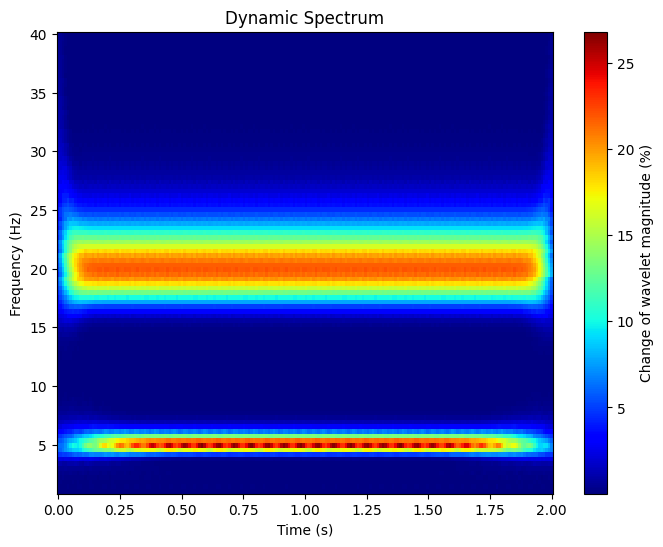

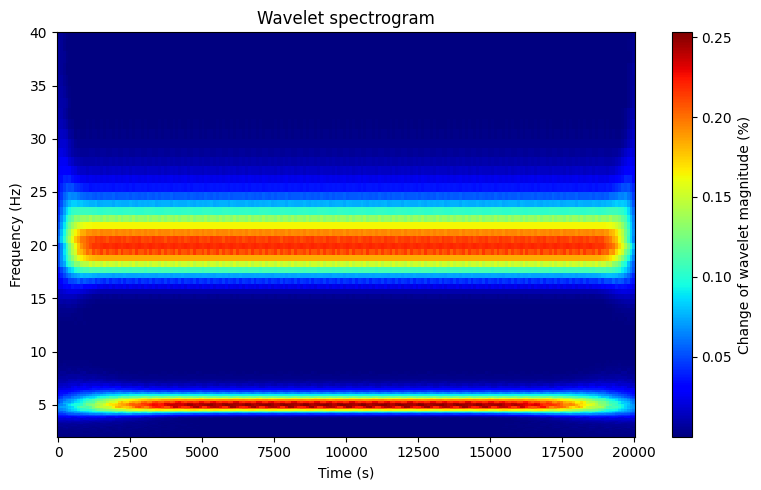

In [16]:
fps = 100  # samples per second
duration = 2  # seconds
t = np.linspace(0, duration, int(fps * duration), endpoint=False)
signal = (
    np.sin(2 * np.pi * 5 * t) +       # 5 Hz
    np.sin(2 * np.pi * 20 * t)    # 20 Hz
)

power_norm, frequencies = dynamic_spectrum(signal, fps, plot=True)
_, _, _ = compute_wavelet_spectrogram(signal, fps)

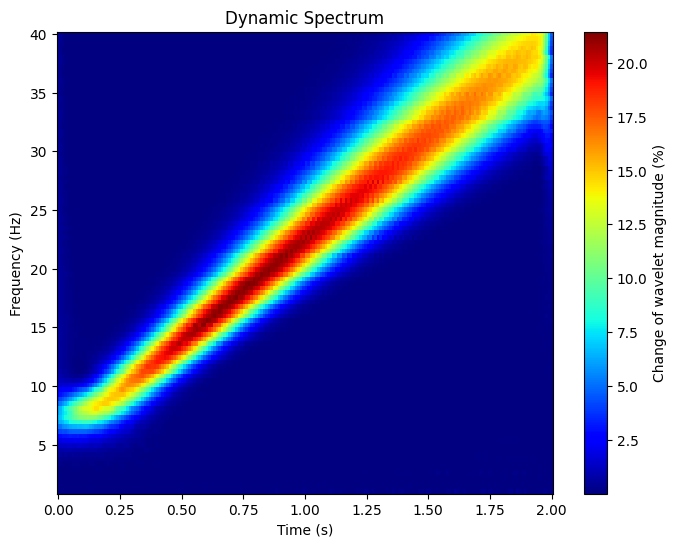

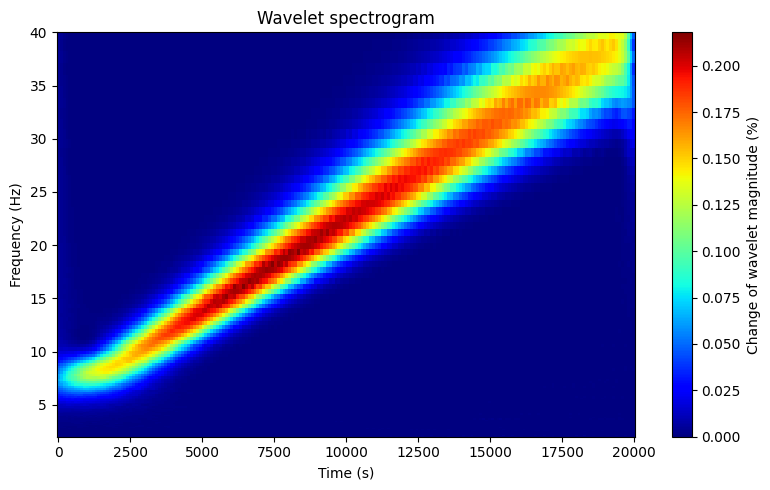

In [17]:
from scipy.signal import chirp

signal = chirp(t, f0=5, f1=40, t1=duration, method='linear')  # 5 Hz to 40 Hz sweep

_, _ = dynamic_spectrum(signal, fps, plot=True)
_, _, _ = compute_wavelet_spectrogram(signal, fps)

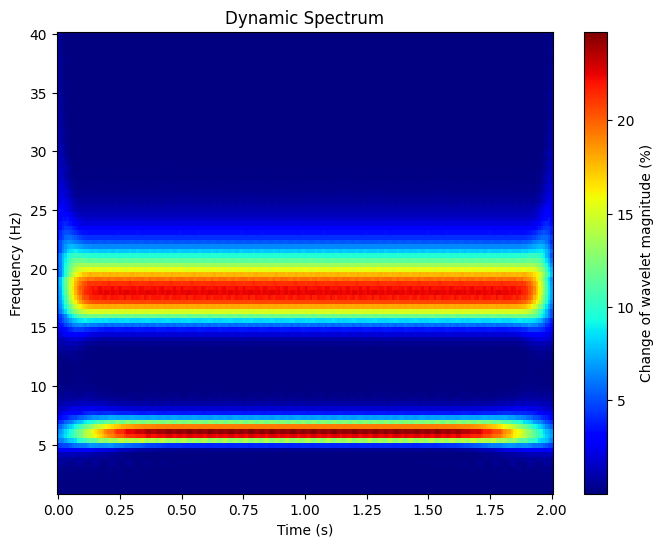

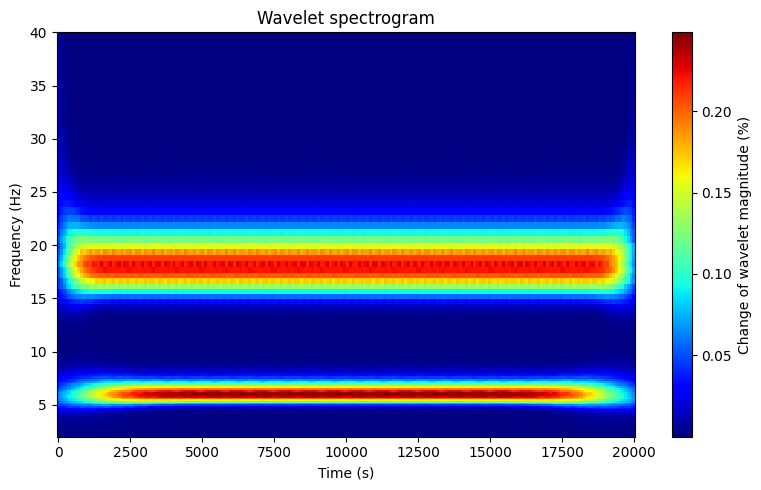

In [19]:
signal = np.sin(2 * np.pi * 6 * t) + np.sin(2 * np.pi * 18 * t)
dynamic_spectrum(signal, fps, plot=True);
_, _, _ = compute_wavelet_spectrogram(signal, fps)

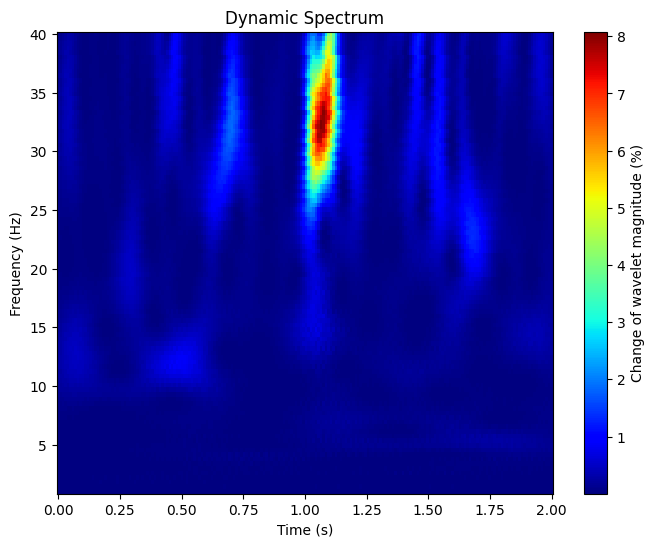

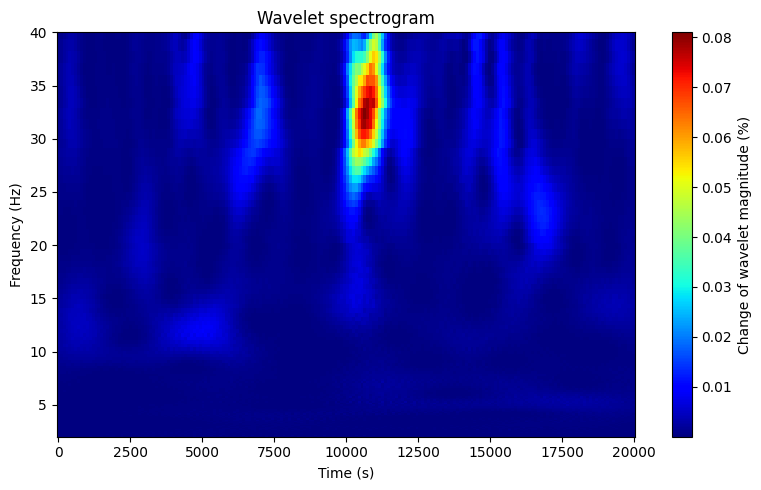

In [20]:
signal = np.random.randn(len(t)) * 0.2  # Background noise
start = int(1.0 * fps)
duration = int(0.1 * fps)
signal[start:start+duration] += np.sin(2 * np.pi * 30 * t[:duration])
dynamic_spectrum(signal, fps, plot=True);

_, _, _ = compute_wavelet_spectrogram(signal, fps)